In [ ]:
#default_exp isola2017image

# Image-to-Image Translation with Conditional Adversarial Networks

Isola, P., Zhu, J. Y., Zhou, T., & Efros, A. A. (2017). Image-to-image translation with conditional adversarial networks. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 1125-1134).

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
from fastpapers.core import *
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files
from fastai.data import *
from fastai.basics import *
from fastai.vision.data import *
from fastai.vision.core import *
from fastcore.all import *
from fastai.vision.augment import *
from fastai.vision.gan import *

In [ ]:
URLs.FACADES_BASE = 'http://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_base.zip'
URLs.FACADES_EXTENDED = 'http://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_extended.zip'

## The Data

We are going to use the CMP Facade Database [1], which is a set of images of building facades and with labels indicating different architecural objects, like window, balcony, door, etc. You can read more on details on its [web page](http://cmp.felk.cvut.cz/~tylecr1/facade/).

Let's use the untar_data function to download the dataset.There are two files, and we'll use both.

In [ ]:
path_base = untar_data(URLs.FACADES_BASE)
path_extended = untar_data(URLs.FACADES_EXTENDED)
get_facade_files = partial(get_image_files, folders=['base', 'extended'])

def get_tuple_files(path):
    files = get_facade_files(path)
    return [sorted(v)[::-1] for v in groupby(files, lambda x: x.stem).values()]

<AxesSubplot:>

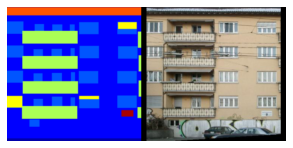

In [ ]:
files = get_tuple_files(path_base.parent)
ToTensor()(Resize(256)(ImageNTuple.create(files[0]))).show()

In [ ]:
im_size = 256
facades = DataBlock(
                    blocks=(ImageBlock, ImageTupleBlock),
                    get_items=get_tuple_files,
                    get_x=itemgetter(0),
                    splitter=RandomSplitter(seed=12),
                    item_tfms=Resize(2*im_size, ResizeMethod.Squish),
                    batch_tfms=[Normalize.from_stats(0.5*torch.ones(3), 0.5*torch.ones(3)), 
                                *aug_transforms(size=im_size,mult=0.1, max_lighting=0, p_lighting=0)],
                    )

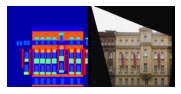

In [ ]:
dls = facades.dataloaders(path_base.parent, bs=1)
dls.show_batch()

## The loss

In [ ]:
#export
def gen_bce_l1_loss(fake_pred, output, target, l1_weight=100):
    l1_loss = nn.L1Loss()(output[-1],target[-1])
    ones = fake_pred.new_ones(*fake_pred.shape)
    bce_loss = nn.BCEWithLogitsLoss()(fake_pred, ones)
    return bce_loss + l1_weight*l1_loss

In [ ]:
#export
def crit_bce_loss(real_pred, fake_pred):
    ones  = real_pred.new_ones(*real_pred.shape)
    zeros = fake_pred.new_zeros(*fake_pred.shape)
    loss_neg = nn.BCEWithLogitsLoss()(fake_pred, zeros)
    loss_pos = nn.BCEWithLogitsLoss()(real_pred, ones)
    return (loss_neg+ loss_pos)/2

In [ ]:
gen_base = gan_critic(n_channels=3, nf=64)
gen_base = nn.Sequential(*list(gen_base.children())[:-2])
generator = ConditionalGenerator(gen_base,3, (256, 256), 
                                 norm_type=NormType.Spectral, 
                                 y_range=(-1,1),
                                 act_cls=partial(nn.LeakyReLU, negative_slope=0.2, inplace=True)
                                 )

In [ ]:
critic = SiameseCritic(n_channels=6, nf=64)

In [ ]:
learn = GANLearner(dls,
                   generator,
                   critic,
                   gen_bce_l1_loss,
                   crit_bce_loss,
                   switcher=FixedGANSwitcher(n_crit=1, n_gen=1),
                   metrics=[l1],
                   opt_func = Adam,
                   switch_eval=False,
                   cbs=[GANDiscriminativeLR(mult_lr=4.)]
                  )
learn.recorder.train_metrics=True
learn.recorder.valid_metrics=False

epoch,train_loss,l1,gen_loss,crit_loss,time
0,20.245272,0.384913,41.883705,0.308533,01:19


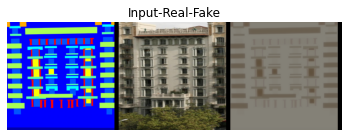

In [ ]:
epochs = 1
learn.fit(epochs, lr_max=0.0001)
learn.show_results(max_n=1, ds_idx=0)

In [ ]:
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_isola2017image.ipynb.
Converted index.ipynb.
